# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-LSTM[SmallWindow]'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18768, 18190)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 6])

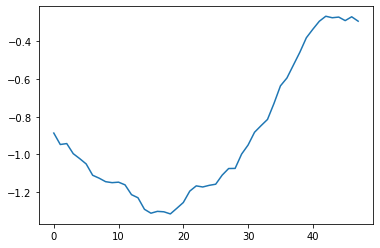

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [16]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  18.749834
 - Pitch        :  10.213320
 - Roll         :   2.588840
 - RMS          :  12.417330
 - 99% Tile     :  43.449733
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.072001
 - Pitch        :   9.335509
 - Roll         :   2.537495
 - RMS          :  10.340145
 - 99% Tile     :  39.030290
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  12.301559
 - Pitch        :   9.009115
 - Roll         :   2.408831
 - RMS          :   8.912444
 - 99% Tile     :  34.072266
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.793650
 - Pitch        :   8.018269
 - Roll         :   2.370071
 - RMS          :   7.434726
 - 99% Tile     :  30.719571
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.384160
 - Pitch        :   7.486548
 - Roll         :   2.381903
 - RMS          :   6.633652
 - 99% Tile     :  27.662629
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.742997
 - Pitch        :   7.579203
 - Roll         :   2.394646
 - RMS          :   6.017936
 - 99% Tile     :  26.058821
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.077142
 - Pitch        :   7.187361
 - Roll         :   2.369527
 - RMS          :   5.603703
 - 99% Tile     :  24.163378
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.865096
 - Pitch        :   6.502765
 - Roll         :   2.348322
 - RMS          :   5.234499
 - 99% Tile     :  21.633247
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.004687
 - Pitch        :   5.794307
 - Roll         :   2.320140
 - RMS          :   4.618944
 - 99% Tile     :  20.144820
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.765392
 - Pitch        :   4.778997
 - Roll         :   2.336372
 - RMS          :   4.123364
 - 99% Tile     :  18.662218
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.941227
 - Pitch        :   3.885591
 - Roll         :   2.374979
 - RMS          :   3.477145
 - 99% Tile     :  16.038305
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.801059
 - Pitch        :   3.014092
 - Roll         :   2.371577
 - RMS          :   2.741962
 - 99% Tile     :  13.521176
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.723697
 - Pitch        :   2.473336
 - Roll         :   2.332387
 - RMS          :   2.515018
 - 99% Tile     :  12.451634
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.496159
 - Pitch        :   2.275270
 - Roll         :   2.347035
 - RMS          :   2.374604
 - 99% Tile     :  11.661418
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.249677
 - Pitch        :   1.798433
 - Roll         :   2.305444
 - RMS          :   2.129983
 - 99% Tile     :  11.267700
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.884330
 - Pitch        :   1.822149
 - Roll         :   2.296780
 - RMS          :   2.012140
 - 99% Tile     :  10.923649
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.965467
 - Pitch        :   1.773607
 - Roll         :   2.270088
 - RMS          :   2.013458
 - 99% Tile     :  10.294694
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.698711
 - Pitch        :   1.642502
 - Roll         :   2.284292
 - RMS          :   1.897491
 - 99% Tile     :  10.380165
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.424476
 - Pitch        :   1.486445
 - Roll         :   2.233732
 - RMS          :   1.753873
 - 99% Tile     :   9.329007
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.591087
 - Pitch        :   1.546494
 - Roll         :   2.185236
 - RMS          :   1.798004
 - 99% Tile     :   8.968654
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.445330
 - Pitch        :   1.323343
 - Roll         :   2.079964
 - RMS          :   1.649896
 - 99% Tile     :   8.849658
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.472144
 - Pitch        :   1.482159
 - Roll         :   1.892631
 - RMS          :   1.627479
 - 99% Tile     :   8.429937
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.225137
 - Pitch        :   1.202641
 - Roll         :   1.627530
 - RMS          :   1.365792
 - 99% Tile     :   7.984023
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.738232
 - Pitch        :   1.578675
 - Roll         :   1.472729
 - RMS          :   1.600270
 - 99% Tile     :   8.527927
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.369730
 - Pitch        :   1.207475
 - Roll         :   1.253579
 - RMS          :   1.278752
 - 99% Tile     :   7.843023
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.140651
 - Pitch        :   1.148849
 - Roll         :   1.065626
 - RMS          :   1.119002
 - 99% Tile     :   7.346135
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.740114
 - Pitch        :   1.328479
 - Roll         :   0.975092
 - RMS          :   1.383673
 - 99% Tile     :   7.562444
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.400874
 - Pitch        :   1.152361
 - Roll         :   0.958852
 - RMS          :   1.184593
 - 99% Tile     :   6.996855
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.364625
 - Pitch        :   1.321283
 - Roll         :   0.900078
 - RMS          :   1.213553
 - 99% Tile     :   7.180793
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.296245
 - Pitch        :   1.024666
 - Roll         :   0.897273
 - RMS          :   1.085555
 - 99% Tile     :   6.963768
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.087422
 - Pitch        :   1.023452
 - Roll         :   0.825752
 - RMS          :   0.985192
 - 99% Tile     :   6.841720
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.089347
 - Pitch        :   1.013584
 - Roll         :   0.855290
 - RMS          :   0.990883
 - 99% Tile     :   6.627786
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.182797
 - Pitch        :   1.143669
 - Roll         :   0.812107
 - RMS          :   1.059325
 - 99% Tile     :   6.760415
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.131617
 - Pitch        :   1.135976
 - Roll         :   0.764392
 - RMS          :   1.025556
 - 99% Tile     :   6.789986
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.137803
 - Pitch        :   1.045808
 - Roll         :   0.771706
 - RMS          :   0.997303
 - 99% Tile     :   6.440029
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.634905
 - Pitch        :   0.926005
 - Roll         :   0.782809
 - RMS          :   1.175186
 - 99% Tile     :   6.527741
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.219122
 - Pitch        :   0.878596
 - Roll         :   0.821912
 - RMS          :   0.988893
 - 99% Tile     :   6.757815
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.428871
 - Pitch        :   0.965070
 - Roll         :   0.805080
 - RMS          :   1.098664
 - 99% Tile     :   6.346696
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.034583
 - Pitch        :   1.057500
 - Roll         :   0.686937
 - RMS          :   0.941727
 - 99% Tile     :   6.425524
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.154718
 - Pitch        :   1.084726
 - Roll         :   0.796431
 - RMS          :   1.023769
 - 99% Tile     :   6.626250
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.125131
 - Pitch        :   1.098226
 - Roll         :   0.706904
 - RMS          :   0.995278
 - 99% Tile     :   6.278877
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.266852
 - Pitch        :   0.879186
 - Roll         :   0.689876
 - RMS          :   0.975331
 - 99% Tile     :   6.139645
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.253721
 - Pitch        :   0.837175
 - Roll         :   0.676860
 - RMS          :   0.954082
 - 99% Tile     :   6.530591
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.221226
 - Pitch        :   1.003694
 - Roll         :   0.634314
 - RMS          :   0.983387
 - 99% Tile     :   6.159511
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.061738
 - Pitch        :   0.835990
 - Roll         :   0.749822
 - RMS          :   0.892263
 - 99% Tile     :   6.232735
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.034788
 - Pitch        :   0.888672
 - Roll         :   0.673569
 - RMS          :   0.878297
 - 99% Tile     :   6.165788
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.251322
 - Pitch        :   0.797429
 - Roll         :   0.771155
 - RMS          :   0.965467
 - 99% Tile     :   5.938031
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.184011
 - Pitch        :   0.966429
 - Roll         :   0.591521
 - RMS          :   0.946179
 - 99% Tile     :   6.271256
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.104986
 - Pitch        :   1.213043
 - Roll         :   0.605422
 - RMS          :   1.009786
 - 99% Tile     :   5.786950
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.176496
 - Pitch        :   0.876674
 - Roll         :   0.599637
 - RMS          :   0.915107
 - 99% Tile     :   5.993587
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.299673
 - Pitch        :   0.890288
 - Roll         :   0.686661
 - RMS          :   0.992181
 - 99% Tile     :   6.053814
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.421169
 - Pitch        :   1.071691
 - Roll         :   0.630566
 - RMS          :   1.090238
 - 99% Tile     :   6.254159
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.240431
 - Pitch        :   0.831751
 - Roll         :   0.637786
 - RMS          :   0.937594
 - 99% Tile     :   6.217714
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.135355
 - Pitch        :   0.872489
 - Roll         :   0.661563
 - RMS          :   0.910666
 - 99% Tile     :   5.973542
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.997049
 - Pitch        :   0.798860
 - Roll         :   0.605647
 - RMS          :   0.816311
 - 99% Tile     :   5.819949
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.109832
 - Pitch        :   0.868853
 - Roll         :   0.597831
 - RMS          :   0.883937
 - 99% Tile     :   6.027255
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.188594
 - Pitch        :   0.866190
 - Roll         :   0.637480
 - RMS          :   0.925459
 - 99% Tile     :   6.013274
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.144570
 - Pitch        :   0.945128
 - Roll         :   0.592334
 - RMS          :   0.922708
 - 99% Tile     :   6.323693
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.103376
 - Pitch        :   0.929091
 - Roll         :   0.559772
 - RMS          :   0.893307
 - 99% Tile     :   5.982700
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.198768
 - Pitch        :   0.880923
 - Roll         :   0.634098
 - RMS          :   0.933658
 - 99% Tile     :   6.046311
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.928974
 - Pitch        :   0.808144
 - Roll         :   0.540743
 - RMS          :   0.776422
 - 99% Tile     :   5.939572
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.078379
 - Pitch        :   0.797600
 - Roll         :   0.559746
 - RMS          :   0.839123
 - 99% Tile     :   5.875493
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.036835
 - Pitch        :   0.848582
 - Roll         :   0.570091
 - RMS          :   0.840659
 - 99% Tile     :   5.913397
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.950556
 - Pitch        :   0.881932
 - Roll         :   0.533116
 - RMS          :   0.809439
 - 99% Tile     :   5.832100
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.930355
 - Pitch        :   0.901242
 - Roll         :   0.540471
 - RMS          :   0.810330
 - 99% Tile     :   5.834625
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.935764
 - Pitch        :   0.781530
 - Roll         :   0.568070
 - RMS          :   0.776562
 - 99% Tile     :   5.710224
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.999031
 - Pitch        :   0.780569
 - Roll         :   0.584331
 - RMS          :   0.805976
 - 99% Tile     :   5.961191
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.931294
 - Pitch        :   0.781319
 - Roll         :   0.529125
 - RMS          :   0.765450
 - 99% Tile     :   5.771445
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.028369
 - Pitch        :   0.895033
 - Roll         :   0.532647
 - RMS          :   0.845052
 - 99% Tile     :   6.016718
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.003249
 - Pitch        :   0.834937
 - Roll         :   0.546588
 - RMS          :   0.816984
 - 99% Tile     :   6.022160
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.129798
 - Pitch        :   0.745104
 - Roll         :   0.535147
 - RMS          :   0.840239
 - 99% Tile     :   5.905451
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.884431
 - Pitch        :   0.854952
 - Roll         :   0.511731
 - RMS          :   0.769205
 - 99% Tile     :   5.819203
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.910241
 - Pitch        :   0.772487
 - Roll         :   0.508039
 - RMS          :   0.749083
 - 99% Tile     :   5.755001
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.895014
 - Pitch        :   0.858553
 - Roll         :   0.524650
 - RMS          :   0.777479
 - 99% Tile     :   5.859719
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.946563
 - Pitch        :   0.853158
 - Roll         :   0.521492
 - RMS          :   0.794945
 - 99% Tile     :   5.910916
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.949414
 - Pitch        :   0.814390
 - Roll         :   0.505242
 - RMS          :   0.778864
 - 99% Tile     :   6.020636
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.916922
 - Pitch        :   0.824054
 - Roll         :   0.518349
 - RMS          :   0.772118
 - 99% Tile     :   5.940279
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.933473
 - Pitch        :   0.772640
 - Roll         :   0.518117
 - RMS          :   0.760874
 - 99% Tile     :   5.783395
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.884420
 - Pitch        :   0.770708
 - Roll         :   0.519541
 - RMS          :   0.740746
 - 99% Tile     :   5.835972
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.878423
 - Pitch        :   0.792629
 - Roll         :   0.509643
 - RMS          :   0.743780
 - 99% Tile     :   5.803104
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.972376
 - Pitch        :   0.799964
 - Roll         :   0.498518
 - RMS          :   0.781873
 - 99% Tile     :   5.942598
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.854619
 - Pitch        :   0.866615
 - Roll         :   0.503773
 - RMS          :   0.760522
 - 99% Tile     :   5.698507
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0082.npy


[0083/0100] Validation: 100%|██████████████████████| 72/72 [00:02<00:00, 33.89it/s, val_loss 2.1363]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.916275
 - Pitch        :   0.804051
 - Roll         :   0.507226
 - RMS          :   0.762307
 - 99% Tile     :   5.799205
Save output signals into checkpoint/1122-Scene3-LSTM[SmallWindow]/sample/0083.npy
